In [1]:
import os
import pandas as pd
import numpy as np
pathresults = "../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","

In [2]:
import plotnine

from plotnine import (
    ggplot,
    aes,
    after_stat,
    geom_histogram,
    facet_wrap,
    facet_grid,
    coord_flip,
    scale_y_continuous,
    scale_y_sqrt,
    scale_y_log10,
    scale_fill_manual,
    theme_bw,
    theme_xkcd

)

In [3]:
def getVal(mypath, filename, header="infer",names = None):
    fullpath = pathresults +mypath+filename
    if names is None:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header).dropna(how= "all", axis=1)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names).dropna(how= "all", axis=1)
    return cst
def get_last_line_as_numpy_array(file_path, dtype = float):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        last_line = lines[-1].strip()

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)

        return array_from_last_line

In [4]:
# voxel val max konz 
GiniMeans = np.full((99,1440),np.nan)
for pSet in range(99):
    path2file = 'none_55_'+str(pSet)+'_10to11_20mn_0s_5/'
    rr = get_last_line_as_numpy_array(path2file+"Soil_solute_conc1.txt")
    # select occupied voxels
    ##
    occVox = np.array(list( set(get_last_line_as_numpy_array(path2file+"seg2cell_vals.csv"))), dtype = int)
    GiniMeans[pSet, occVox] = rr[occVox]

In [5]:
GiniMeans1 = GiniMeans.reshape(-1)
GiniMeans1 = GiniMeans1[~np.isnan(GiniMeans1)]

In [6]:
min([np.nanmax(gg) for gg in GiniMeans])

1.9048721764153132e-06

In [7]:
len(GiniMeans1)/99
np.percentile(GiniMeans1, 50)

8.403706063608914e-06

In [8]:
data0 = pd.DataFrame(GiniMeans[0], columns=['GradMean'])
data = pd.DataFrame(GiniMeans1, columns=['GradMean'])

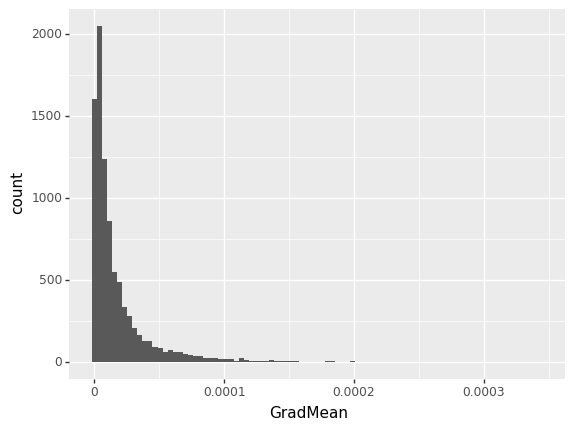

<ggplot: (8778988534047)>

In [9]:
(
    ggplot(data, aes(x='GradMean'))
    + geom_histogram(bins = np.floor(len(data['GradMean'])/100))
)

In [82]:
# cylinder max konz (per cell)

GiniMeans = np.full(99,np.nan)
GiniAll =[[] for i in range(99)]
for pSet in range(99):
    
    path2file = 'none_55_'+str(pSet)+'_10to11_20mn_0s_5/'
    rr = get_last_line_as_numpy_array(path2file+"root_segments_tips.txt", dtype =int)

    Ginits = np.full(len(rr),np.nan)
    for idx, gId in enumerate(rr):
        #gId = rr[0]
        
        fileName = "Cyl_cellVol_"+str(gId)+".txt"
        cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        fileName = "Cyl_watercontent_"+str(gId)+".txt"
        theta = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        fileName = "Cyl_content1_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName, dtype = float)

        konz = Q1/(cVol * theta)#mol/cm3
        Ginits[idx] = max( konz)
    GiniMeans[pSet] = max(Ginits)
    GiniAll[pSet] = Ginits
    

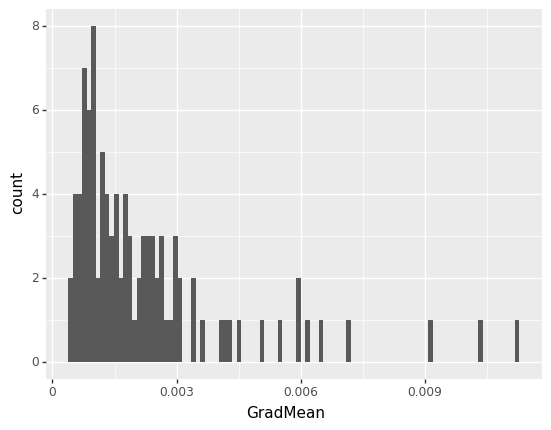

<ggplot: (8778981891151)>

In [83]:
data = pd.DataFrame(GiniMeans.reshape(-1), columns=['GradMean'])
(
    ggplot(data, aes(x='GradMean'))
    + geom_histogram(bins = np.floor(len(data['GradMean'])))
)

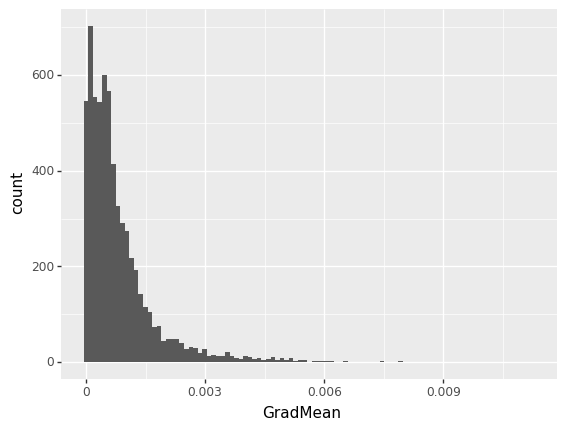

<ggplot: (8778982063144)>

In [84]:
Gall = np.array(GiniAll)
dataAll = pd.DataFrame(Gall.reshape(-1), columns=['GradMean'])
(
    ggplot(dataAll, aes(x='GradMean'))
    + geom_histogram(bins = np.floor(len(data['GradMean'])))
)

In [85]:
# get param set
paramsets =  pd.read_csv('../output_random_rows.csv')
paramsets = paramsets.drop(paramsets.columns.tolist()[-1],axis=1)

In [86]:

column_names = ['coucou']+paramsets.columns.tolist()
df = pd.DataFrame(columns=column_names)
for pset in range(99):
    N = Gall[pset].shape[0]
    rows_to_duplicate_df = pd.DataFrame(paramsets.iloc[pset]).T
    duplicated_rows_df = rows_to_duplicate_df.loc[np.repeat(rows_to_duplicate_df.index.values, N)]
    # Duplicate the specific rows N times
    duplicated_rows_df['coucou']=Gall[pset]

    # Concatenate the original DataFrame with the duplicated specific rows
    df = pd.concat([df, duplicated_rows_df], ignore_index=True)

In [87]:
df.shape

(6336, 28)

In [88]:
import matplotlib.pyplot as plt

In [89]:

continuous_variable = 'coucou'
other_continuous_variables = paramsets.columns.tolist()

# Calculate correlation
correlation = [df[continuous_variable].corr(df[other_continuous_variables[pp]]) for pp in range(len(other_continuous_variables))]

print("Correlation between", continuous_variable, "and other continuous variables:")
print(correlation)

Correlation between coucou and other continuous variables:
[-0.01881273648541558, -0.1624793365330697, 0.021433677130739147, 0.1839240278944496, -0.40127015501488794, -0.028397413755771768, -0.10280719288978267, -0.14387065454387332, -0.08652164892080852, 0.13244995803572954, -0.17009898505074966, -0.2347883624727113, 0.07347766851123162, 0.020561425115961457, 0.021345968753962215, 0.1811870834833457, -0.09628564064747669, -0.005746276501625972, 0.012547856776662073, 0.13464645117893406, 0.1960268431621886, 0.16793776045607858, 0.10794407956510131, -0.16297242653436672, 0.140582752583788, -0.02076584290808986, 0.013804644122907026]


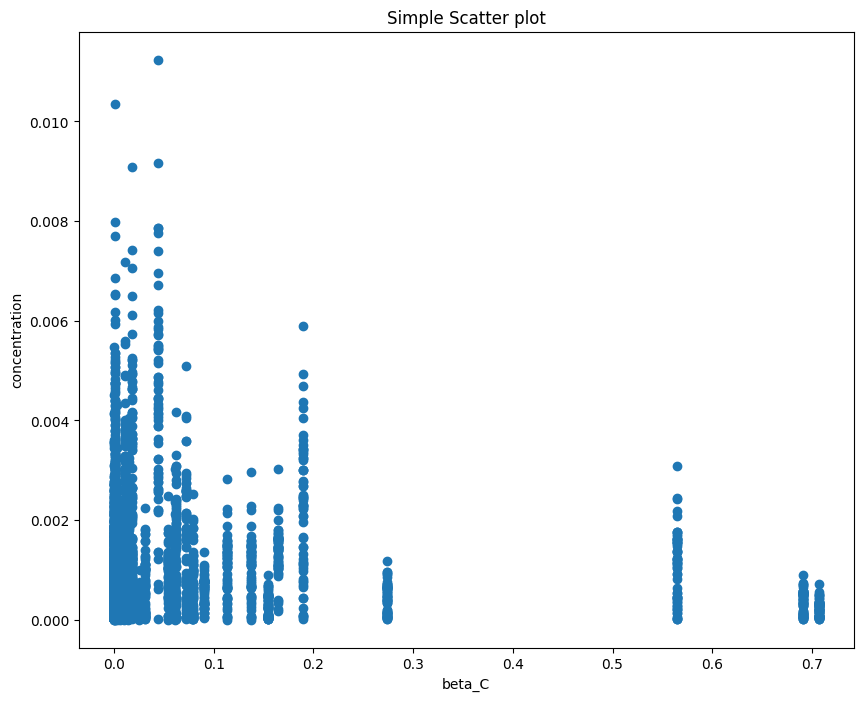

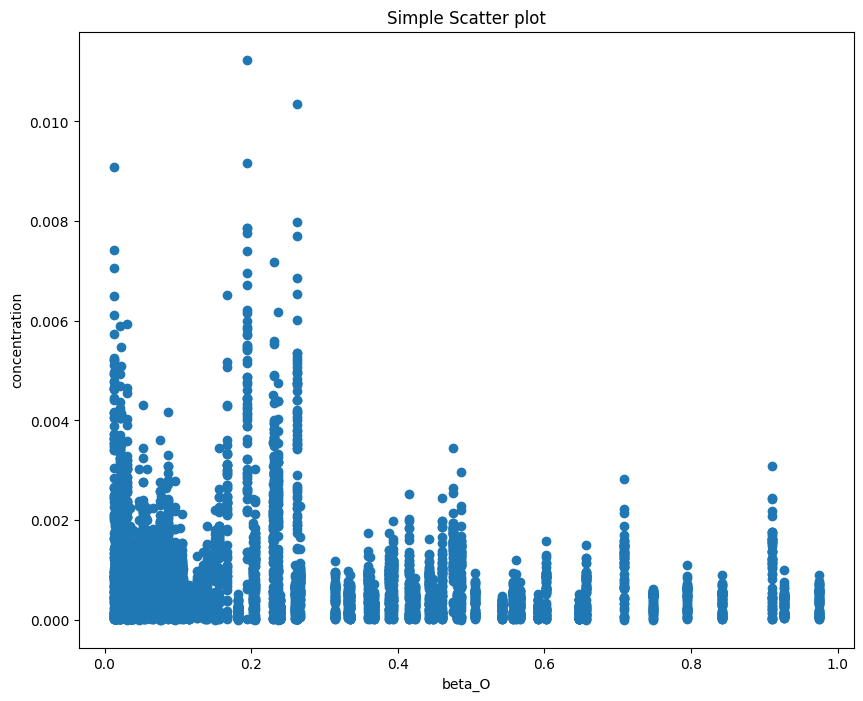

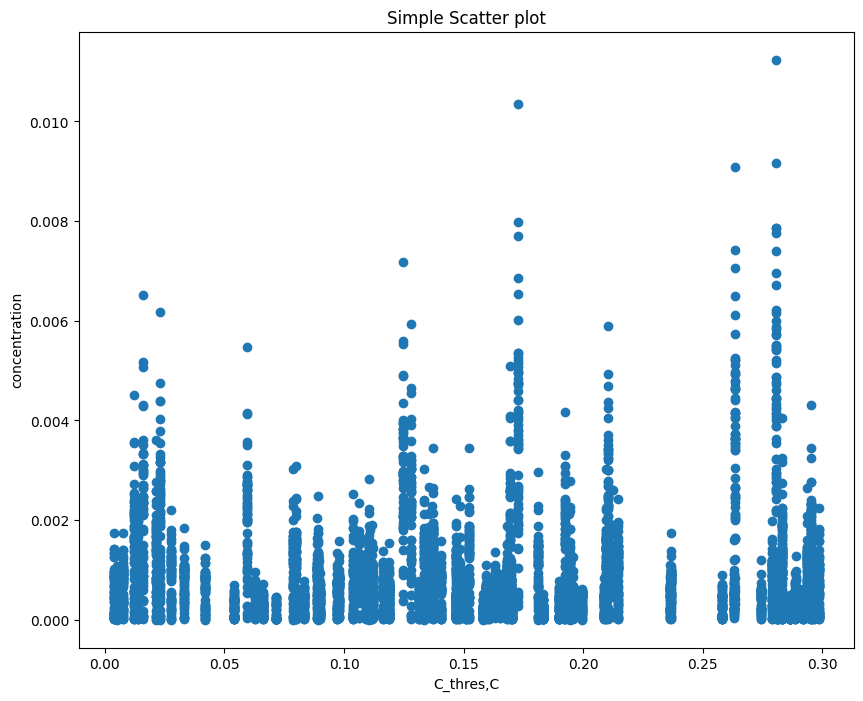

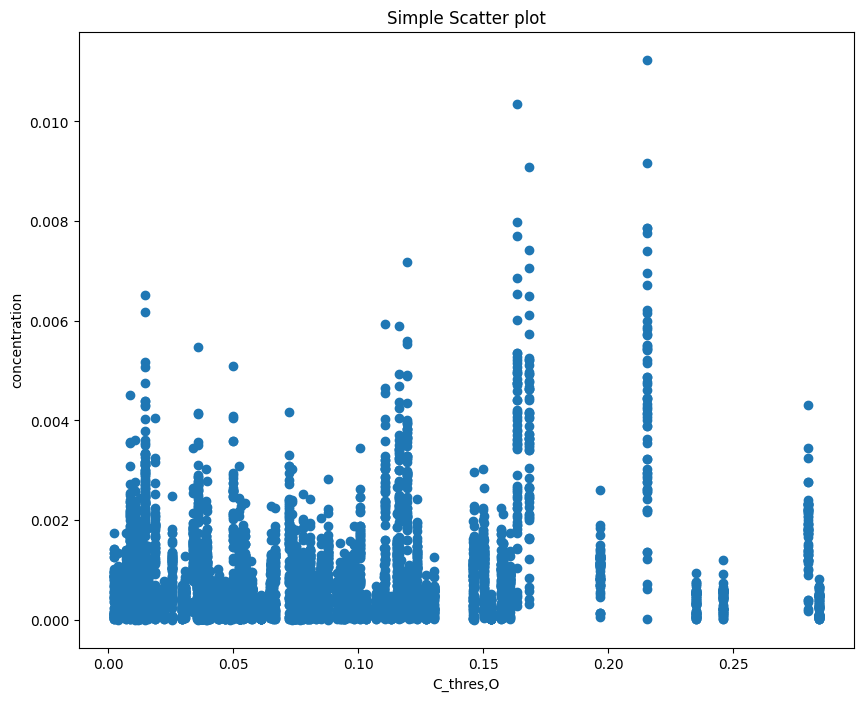

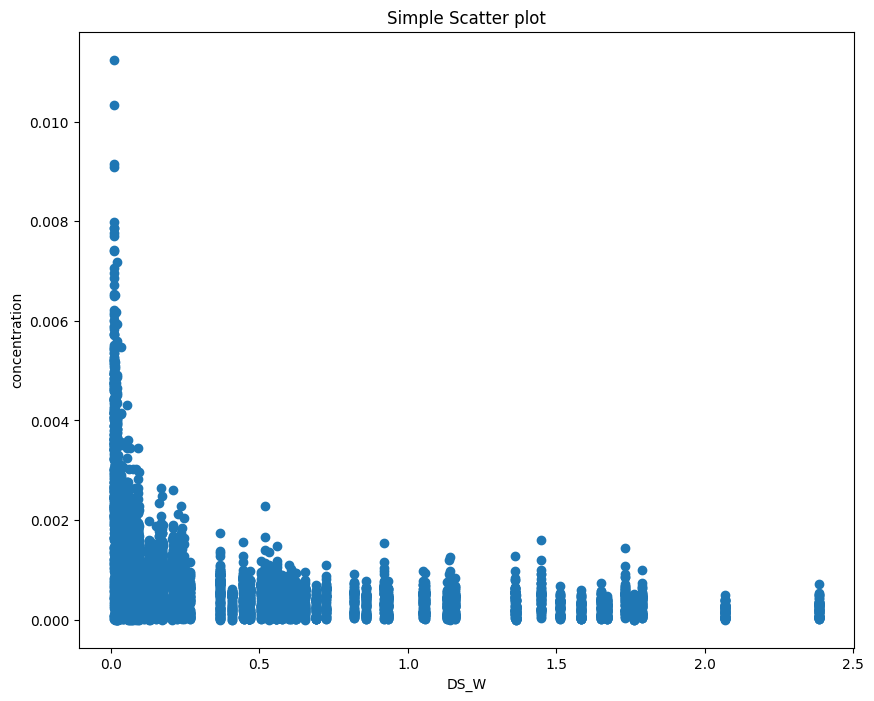

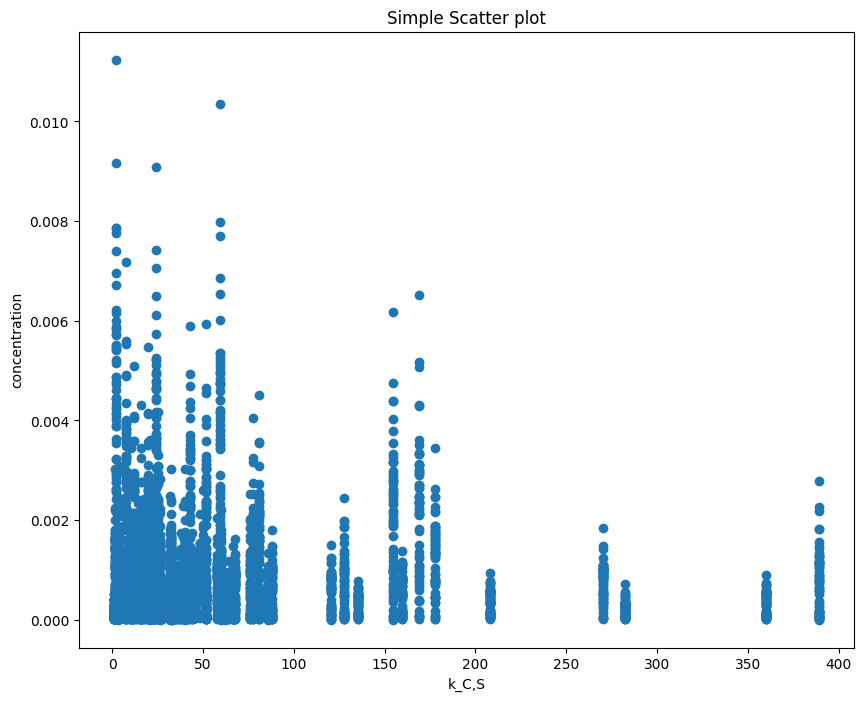

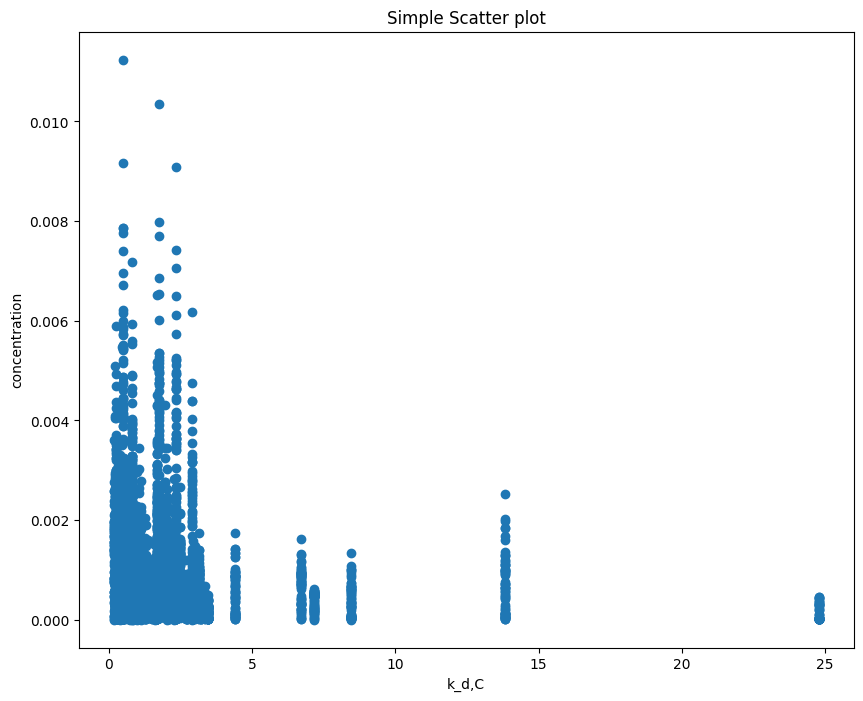

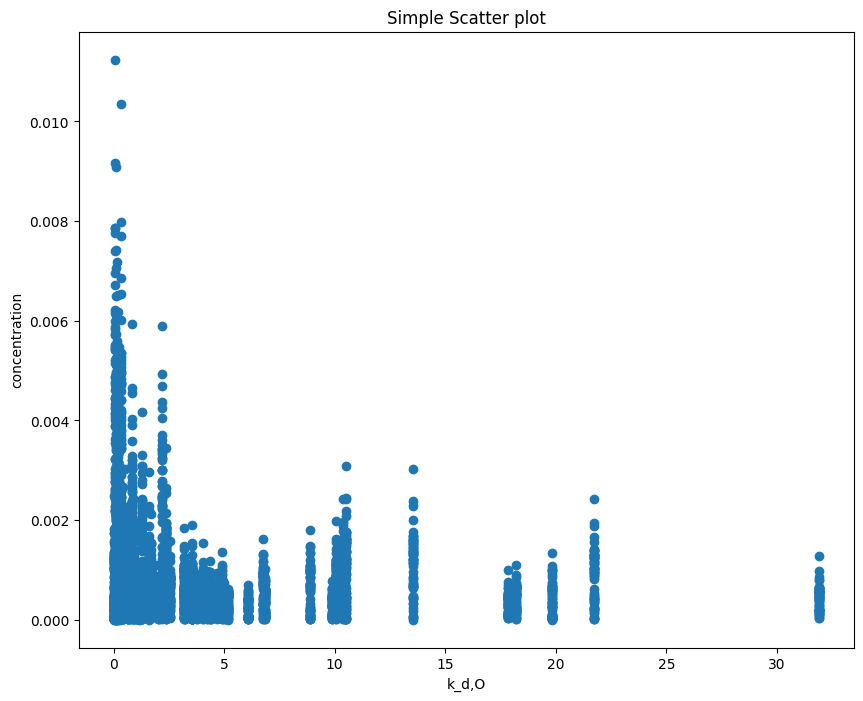

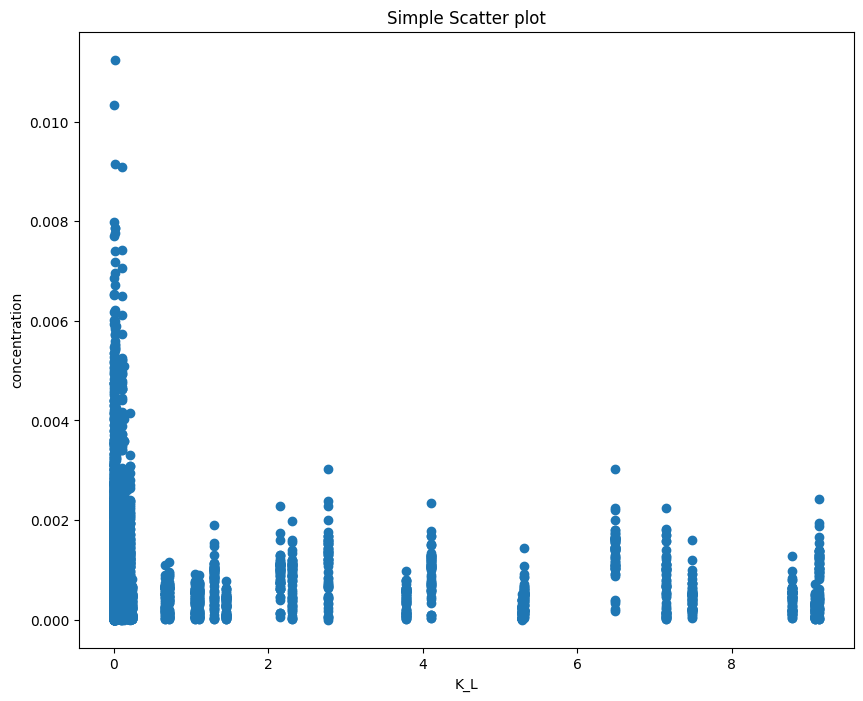

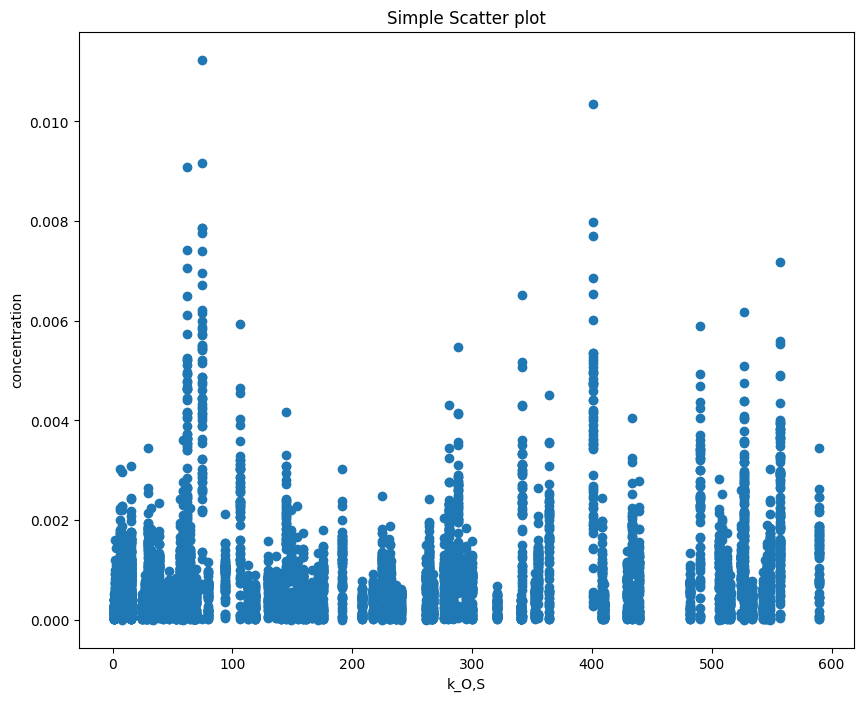

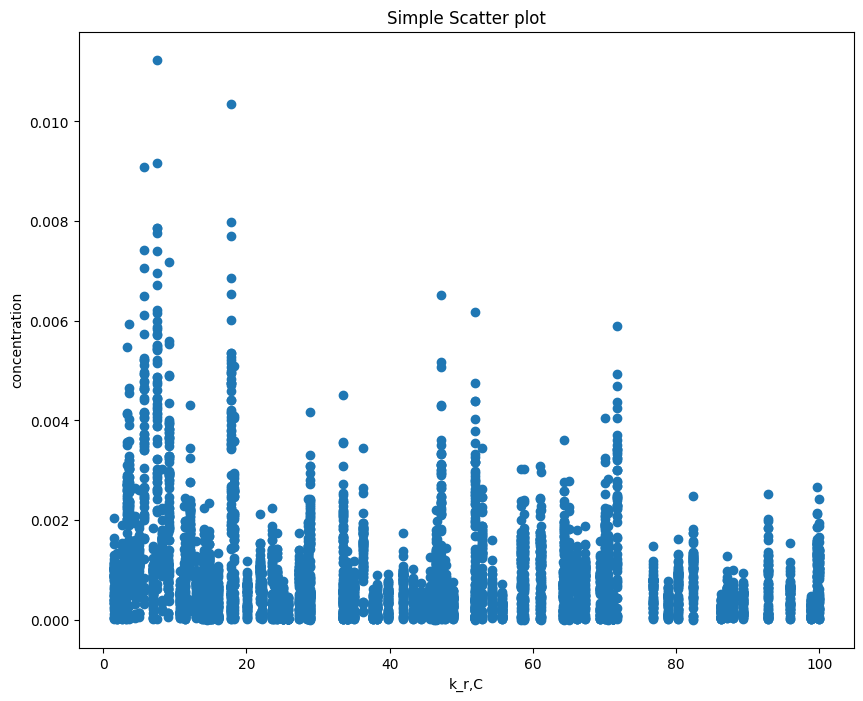

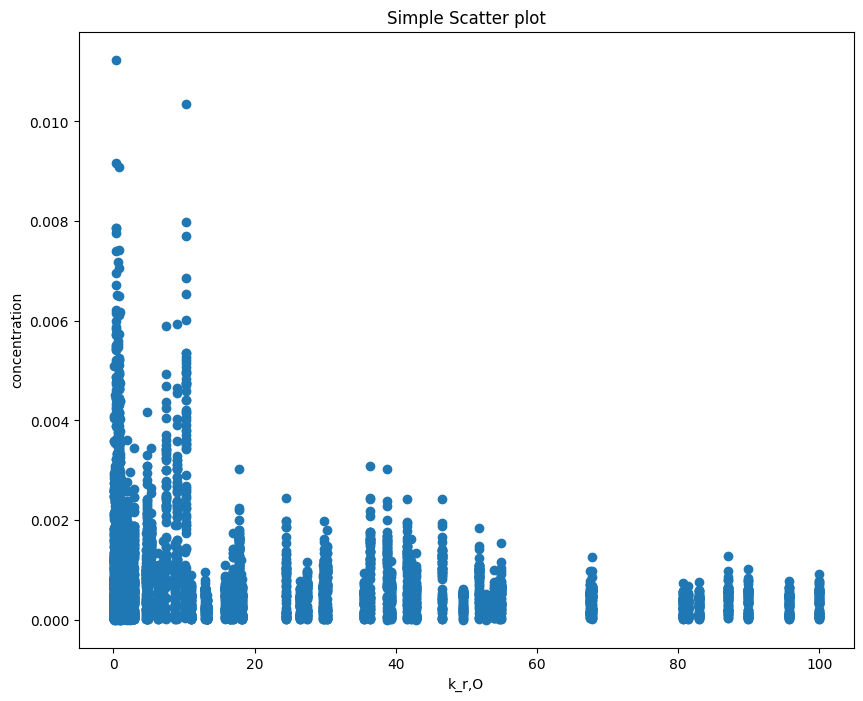

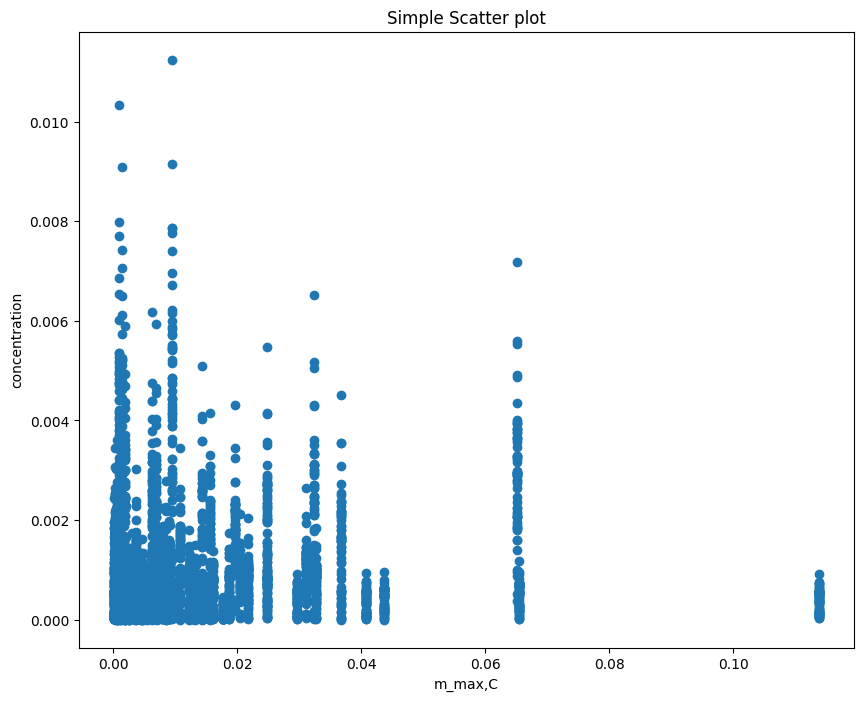

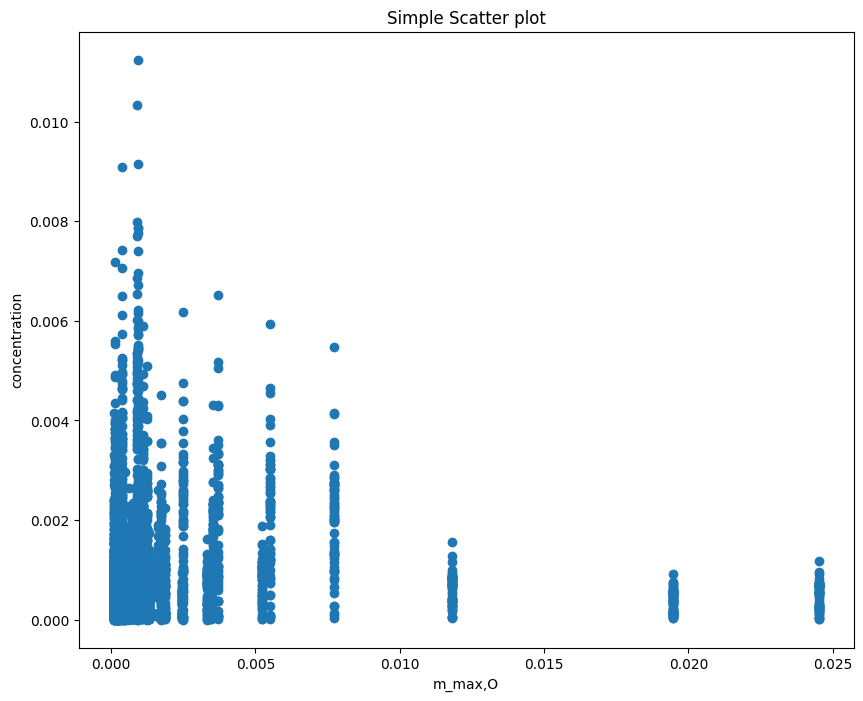

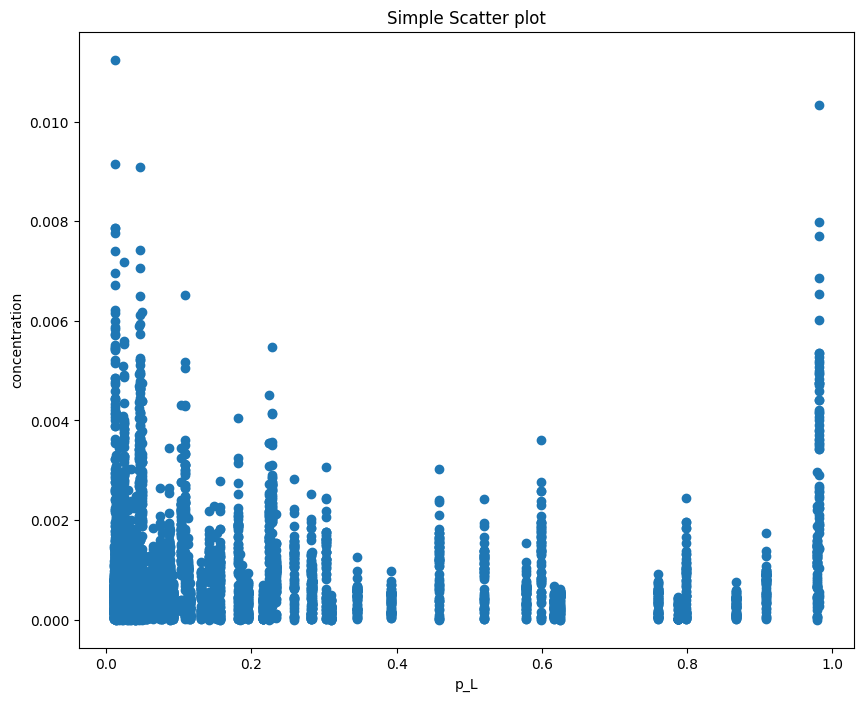

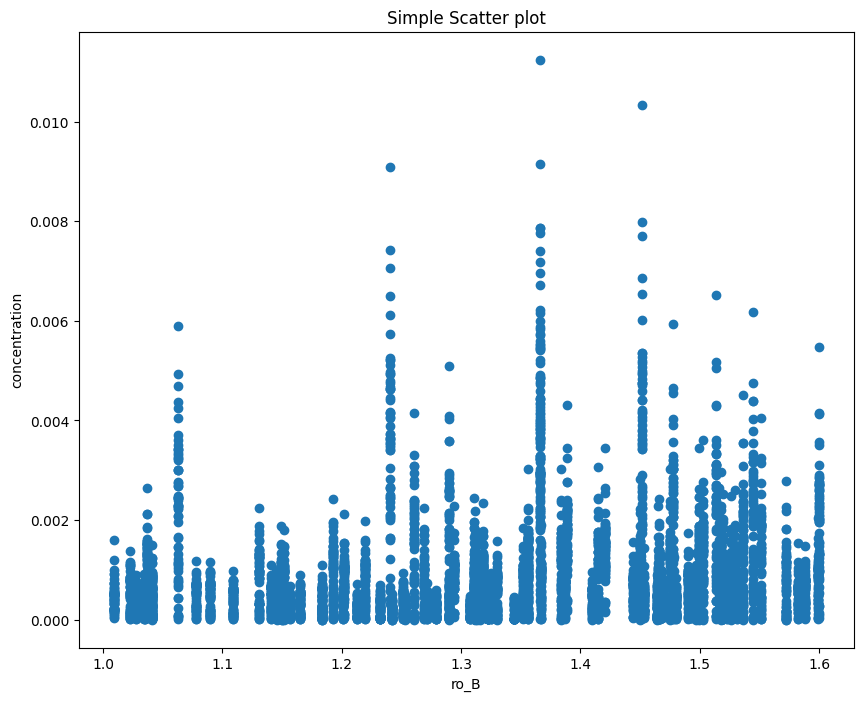

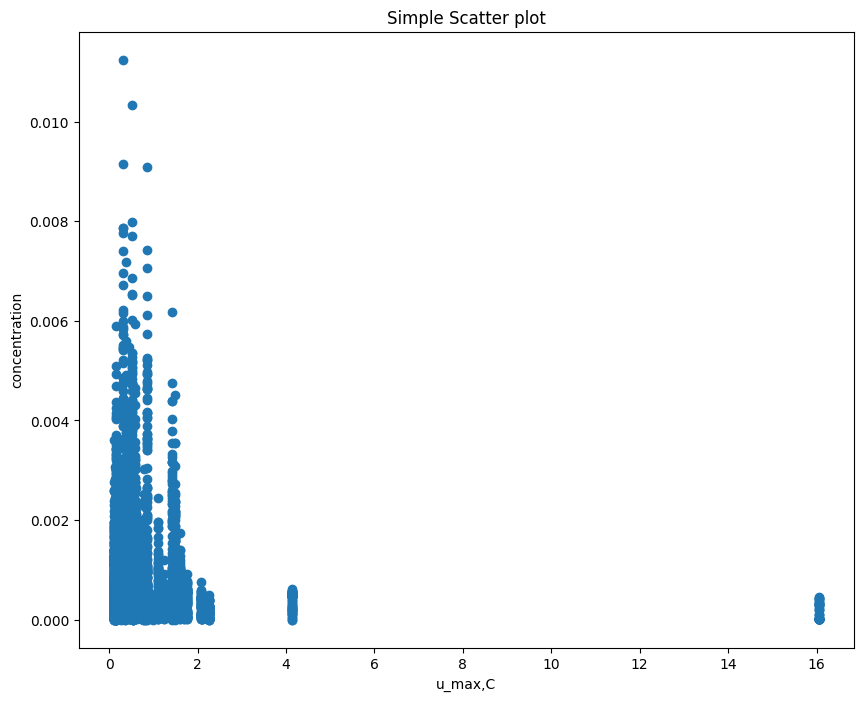

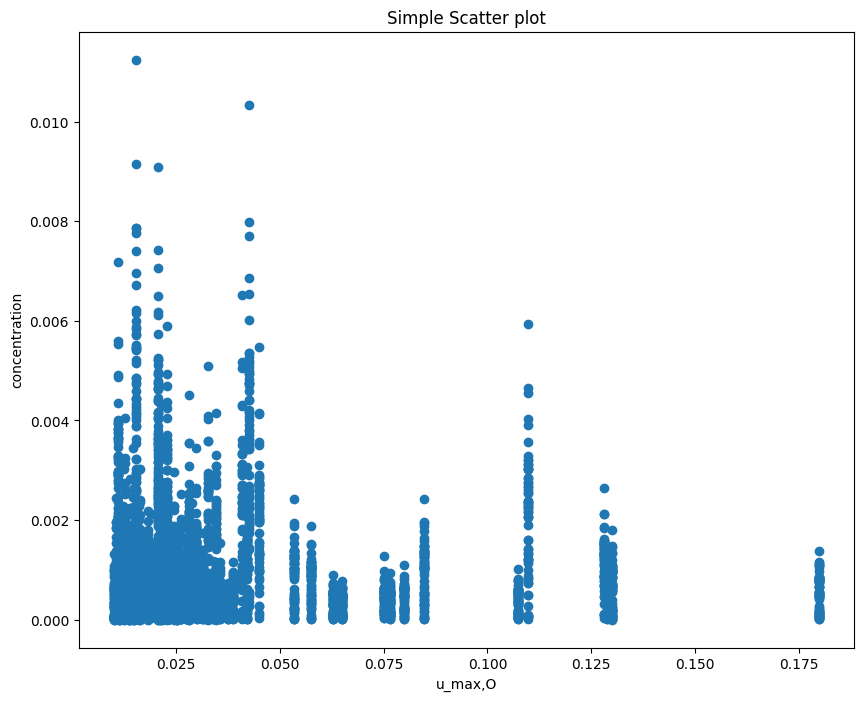

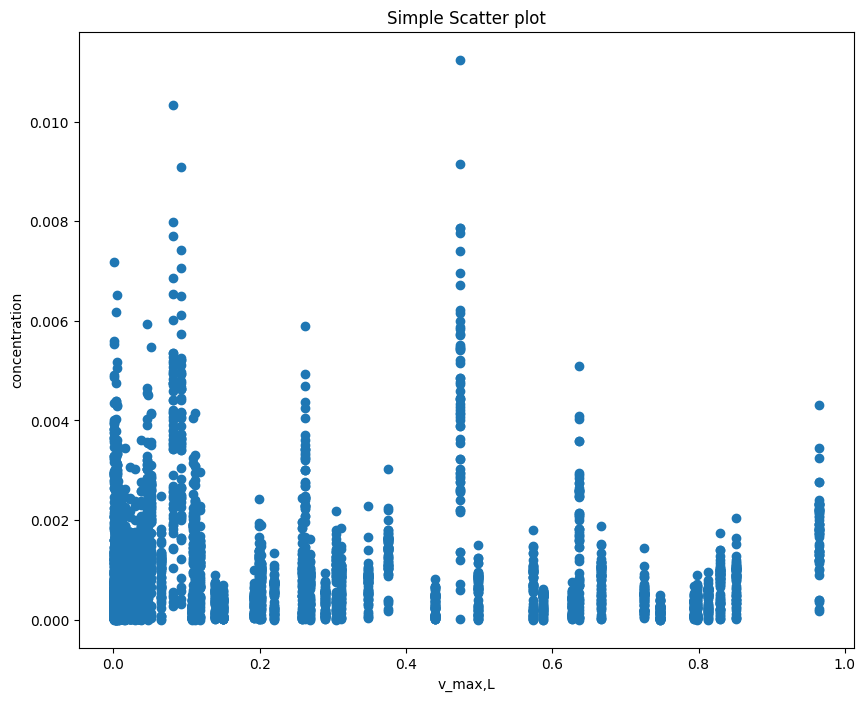

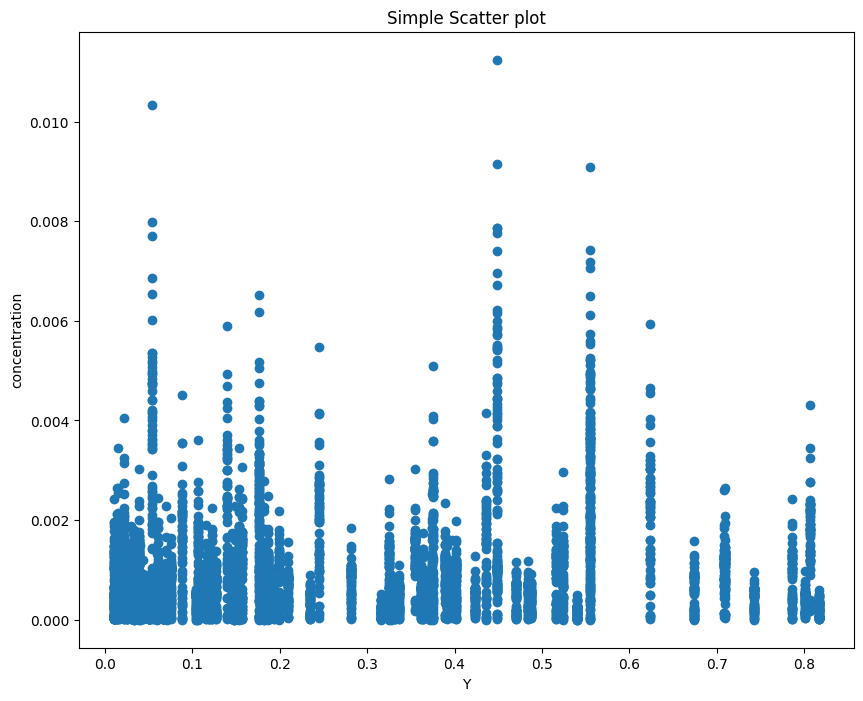

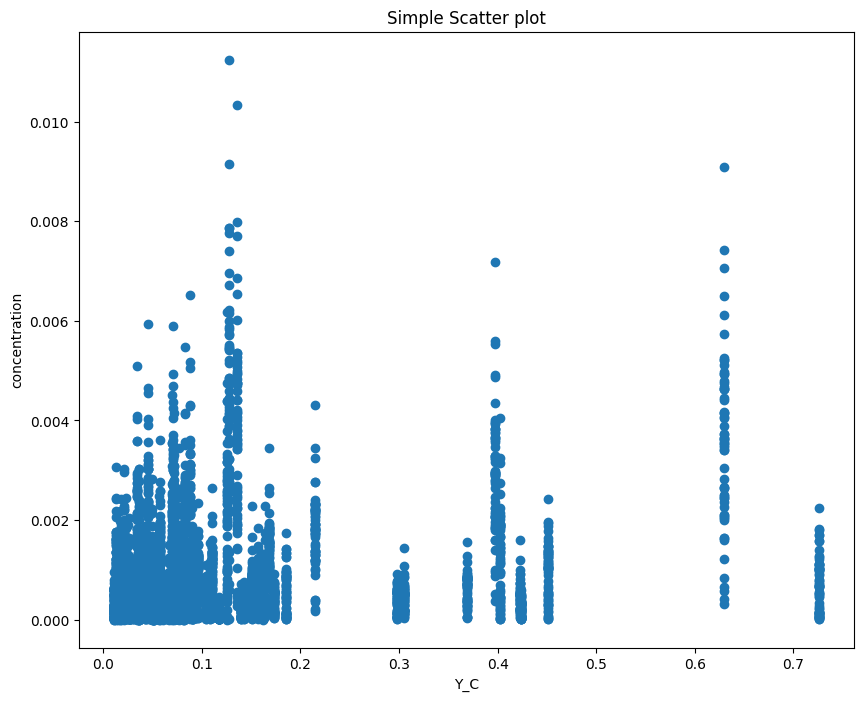

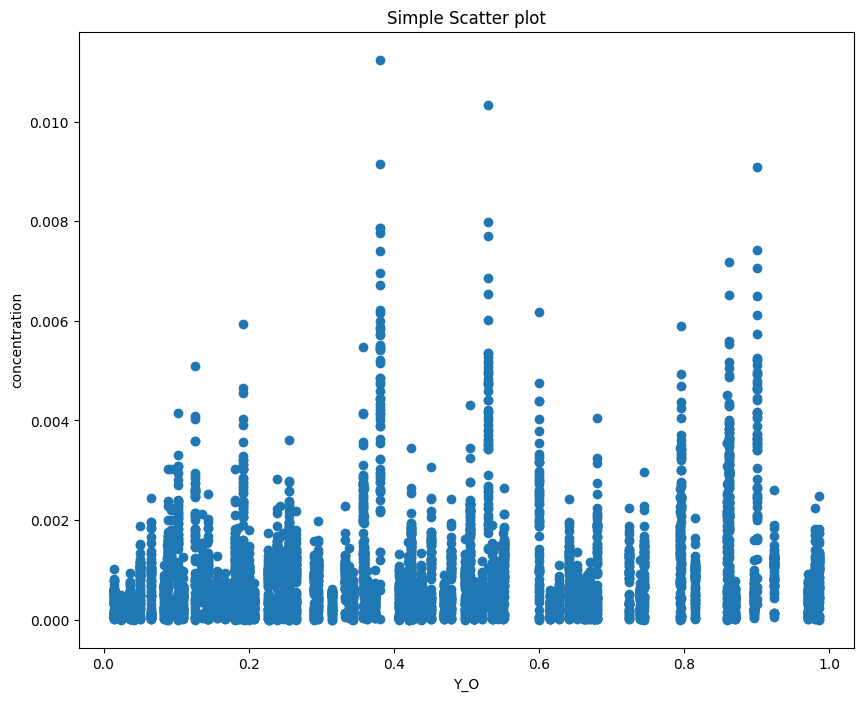

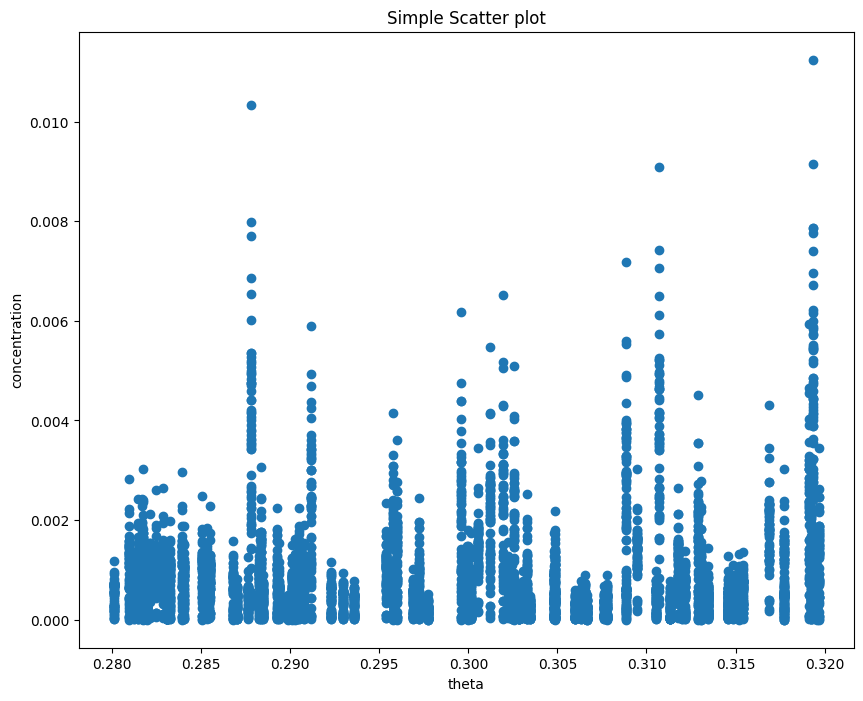

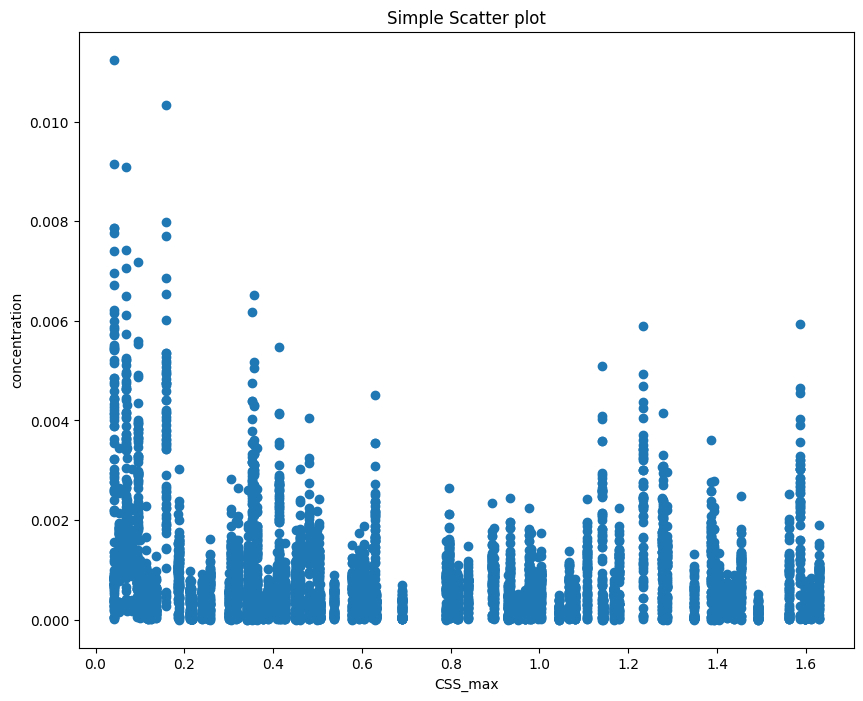

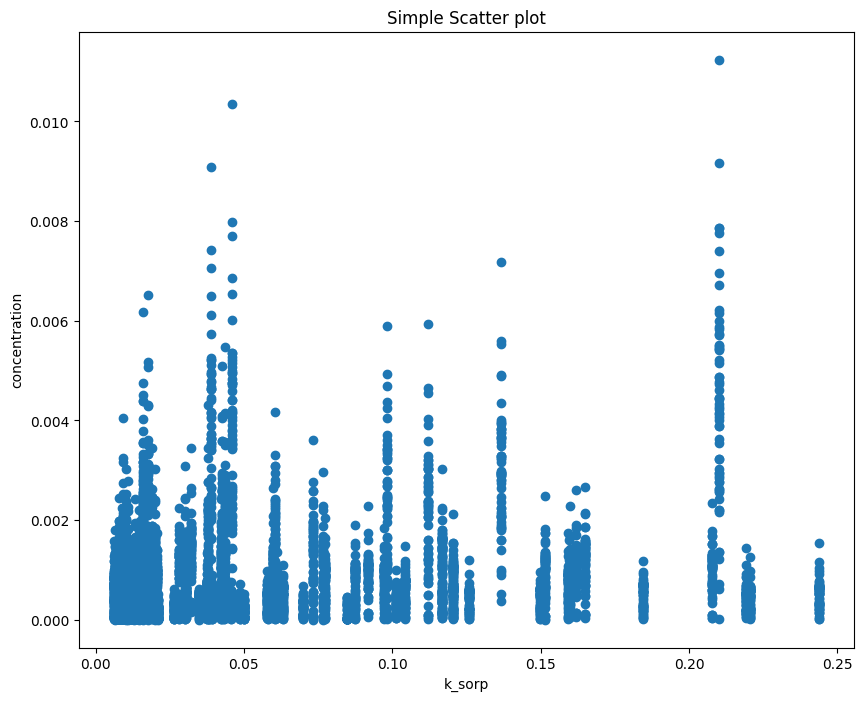

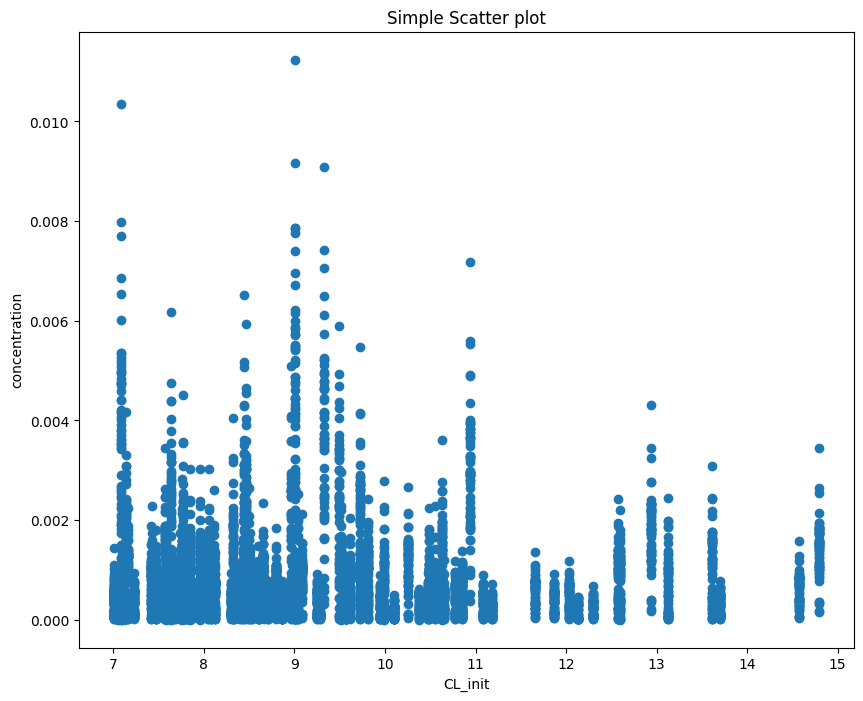

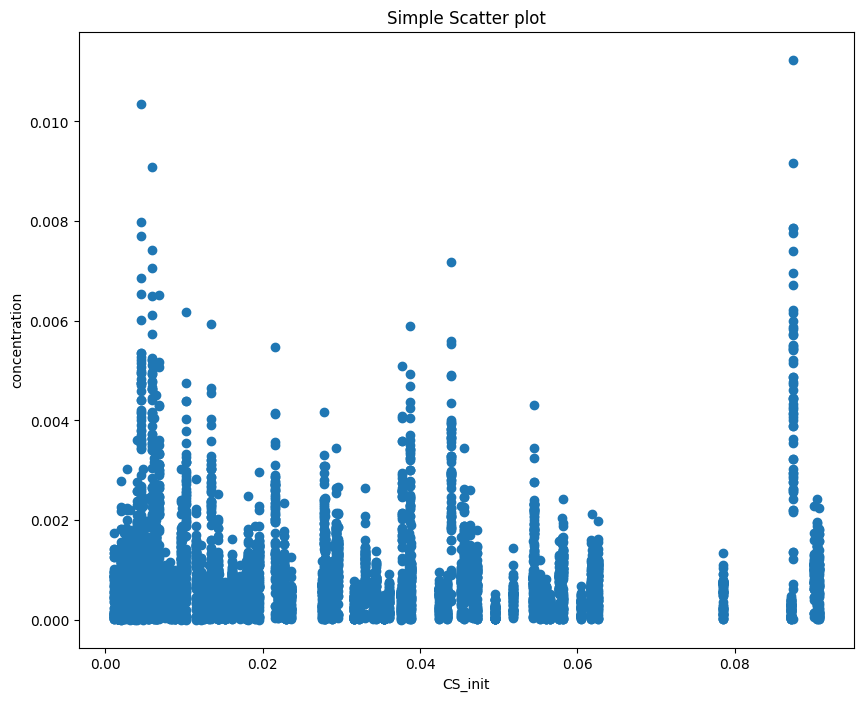

In [90]:

for ii in range(len(other_continuous_variables)):
    plt.scatter(df[other_continuous_variables[ii]],df[continuous_variable])
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title('Simple Scatter plot')
    plt.xlabel(other_continuous_variables[ii])
    plt.ylabel('concentration')
    plt.show()

In [ ]:
paramsets

In [26]:
problem = {
        'num_vars': len(GiniMeans),
        'names': namesVars_phlo,
        'bounds': namesLim_phlo
    }

0.00034320317119243456


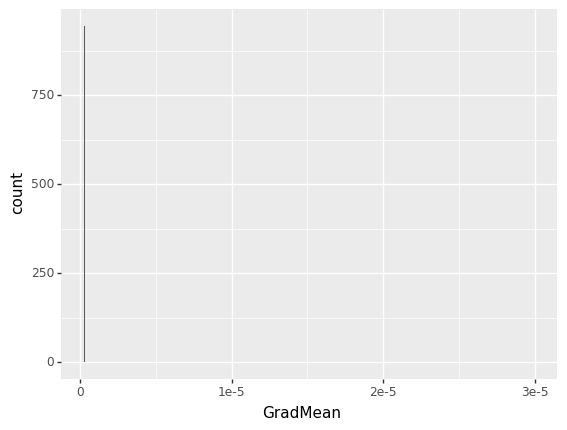

<ggplot: (8794740057697)>

In [34]:
(
    ggplot(data0, aes(x='GradMean'))
    + geom_histogram(bins = np.floor(len(data0['GradMean'])))
)

In [ ]:
#better histokonz for cylindesr
GiniMeans = []
for pSet in range(99):
    path2file = pathresults + 'param99none'+str(pSet)+'0dx_2dumux_10c_10.0to11.0_20mn_0s_192_100/'
    rr = get_last_line_as_numpy_array(path2file+"root_segments_tips.txt")
    Ginits = np.full(len(rr),np.nan)
    print('\npSet',pSet, 'len(rr)',len(rr))
    for idx, gId in enumerate(rr):
        print('rootid',idx, end =", ")
        #gId = rr[0]
        fileName = "Cyl_cellVol_"+str(gId)+".txt"
        cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        fileName = "Cyl_content1_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        fileName = "Cyl_watercontent_"+str(gId)+".txt"
        theta = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        fileName = "Cyl_coord_"+str(gId)+".txt"
        dofc = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        watVol = theta * cVol
        if False:
            konz = Q1/cVol #mol/cm3
        else:
            konz = Q1/watVol #mol/cm3
        Ginits[idx] = (np.diff( Q1/cVol)/np.diff(dofc))[0]
    GiniMeans[pSet] = np.mean(Ginits)